# M5 Forecasting with Tweedie loss





### Standard imports

First we import standard data manipulation libraries.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm
from pathlib import Path

In [2]:
from gluonts.torch.model.deepar import DeepARModel
from gluonts.torch.model.deepar.estimator import DeepAREstimator
#from gluonts.torch.modules.distribution_output import NegativeBinomialOutput
import pytorch_lightning as pl

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


# Data processing

In [3]:
single_prediction_length = 28
submission_prediction_length = single_prediction_length * 2
m5_input_path="./Data/m5-forecasting-accuracy"
submission=False

if submission:
    prediction_length = submission_prediction_length
else:
    prediction_length = single_prediction_length

### Reading the M5 data into GluonTS

First we need to convert the provided M5 data into a format that is readable by GluonTS. At this point we assume that the M5 data, which can be downloaded from Kaggle, is present under `m5_input_path`.

In [4]:
calendar = pd.read_csv(f'{m5_input_path}/calendar.csv')
sales_train_validation = pd.read_csv(f'{m5_input_path}/sales_train_validation.csv')
sample_submission = pd.read_csv(f'{m5_input_path}/sample_submission.csv')
sell_prices = pd.read_csv(f'{m5_input_path}/sell_prices.csv')

In [5]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [6]:
print(calendar.shape,
sales_train_validation.shape,
sell_prices.shape)

(1969, 14) (30490, 1919) (6841121, 4)


We start the data convertion process by building dynamic features (features that change over time, just like the target values). Here, we are mainly interested in the event indicators `event_type_1` and `event_type_2`. We will mostly drop dynamic time features as GluonTS will automatically add some of these as part of many models' transformation chains.

In [9]:
cal_features = calendar.drop(
    ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'd'], 
    axis=1
)
cal_features['event_type_1'] = cal_features['event_type_1'].apply(lambda x: 0 if str(x)=="nan" else 1)
cal_features['event_type_2'] = cal_features['event_type_2'].apply(lambda x: 0 if str(x)=="nan" else 1)

test_cal_features = cal_features.values.T
if submission:
    train_cal_features = test_cal_features[:,:-submission_prediction_length]
else:
    train_cal_features = test_cal_features[:,:-submission_prediction_length-single_prediction_length]
    test_cal_features = test_cal_features[:,:-submission_prediction_length]

test_cal_features_list = [test_cal_features] * len(sales_train_validation)
train_cal_features_list = [train_cal_features] * len(sales_train_validation)

We then go on to build static features (features which are constant and series-specific). Here, we make use of all categorical features that are provided to us as part of the M5 data.

In [10]:
state_ids = sales_train_validation["state_id"].astype('category').cat.codes.values
state_ids_un , state_ids_counts = np.unique(state_ids, return_counts=True)

store_ids = sales_train_validation["store_id"].astype('category').cat.codes.values
store_ids_un , store_ids_counts = np.unique(store_ids, return_counts=True)

cat_ids = sales_train_validation["cat_id"].astype('category').cat.codes.values
cat_ids_un , cat_ids_counts = np.unique(cat_ids, return_counts=True)

dept_ids = sales_train_validation["dept_id"].astype('category').cat.codes.values
dept_ids_un , dept_ids_counts = np.unique(dept_ids, return_counts=True)

item_ids = sales_train_validation["item_id"].astype('category').cat.codes.values
item_ids_un , item_ids_counts = np.unique(item_ids, return_counts=True)

stat_cat_list = [item_ids, dept_ids, cat_ids, store_ids, state_ids]

stat_cat = np.concatenate(stat_cat_list)
stat_cat = stat_cat.reshape(len(stat_cat_list), len(item_ids)).T

stat_cat_cardinalities = [len(item_ids_un), len(dept_ids_un), len(cat_ids_un), len(store_ids_un), len(state_ids_un)]

Finally, we can build both the training and the testing set from target values and both static and dynamic features.

In [11]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

train_df = sales_train_validation.drop(["id","item_id","dept_id","cat_id","store_id","state_id"], axis=1)
train_target_values = train_df.values

if submission == True:
    test_target_values = [np.append(ts, np.ones(submission_prediction_length) * np.nan) for ts in train_df.values]
else:
    test_target_values = train_target_values.copy()
    train_target_values = [ts[:-single_prediction_length] for ts in train_df.values]

m5_dates = [pd.Timestamp("2011-01-29", freq='1D') for _ in range(len(sales_train_validation))]

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: fdr,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fdr, fsc) in zip(train_target_values,
                                         m5_dates,
                                         train_cal_features_list,
                                         stat_cat)
], freq="D")

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: fdr,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fdr, fsc) in zip(test_target_values,
                                         m5_dates,
                                         test_cal_features_list,
                                         stat_cat)
], freq="D")

/var/folders/gr/ff8nqlbn5yj2xyvj129ggsfh0000gp/T/ipykernel_68950/289369799.py:13: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  m5_dates = [pd.Timestamp("2011-01-29", freq='1D') for _ in range(len(sales_train_validation))]


In [12]:
len(train_target_values), len(m5_dates),len(train_cal_features_list),len(stat_cat)

(30490, 30490, 30490, 30490)

Just to be sure, we quickly verify that dataset format is correct and that our dataset does indeed contain the correct target values as well as dynamic and static features.

### Define the Tweedie loss function

In [13]:
from gluonts.torch.model.deepar import DeepARModel
from gluonts.torch.model.deepar.estimator import DeepAREstimator
from gluonts.torch.modules.distribution_output import NegativeBinomialOutput
import pytorch_lightning as pl

In [14]:
import torch
import numpy as np
from torch.distributions.distribution import Distribution
from gluonts.torch.modules.distribution_output import DistributionOutput
import torch.nn.functional as F
from typing import Callable, Dict, Optional, Tuple, List
from gluonts.core.component import validated
from torch.distributions.utils import broadcast_all, probs_to_logits, lazy_property, logits_to_probs
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


def est_lambda(mu, p):
    return mu ** (2 - p) / (2 - p)

def est_alpha(p):
    return (2 - p) / (p - 1)    

def est_beta(mu, p):
    return mu ** (1 - p) / (p - 1)


class Tweedie(Distribution):
    r"""
    Creates a Tweedie distribution, i.e. distribution
    
    Args:    
        log_mu (Tensor): log(mean)
        rho (Tensor): tweedie_variance_power (1 ~ 2)
    """
    @validated()
    def __init__(self, log_mu, rho, validate_args=None):
        self.log_mu = log_mu
        self.rho = rho

        batch_shape = log_mu.size()
        super(Tweedie, self).__init__(batch_shape, validate_args=validate_args)

    @property
    def mean(self):
        return torch.exp(self.log_mu)

    @property
    def variance(self):
        return self.rho * torch.ones_like(self.log_mu) # FIX THIS

    @lazy_property
    def _gamma(self):
        # Note we avoid validating because self.total_count can be zero.
        return torch.distributions.Gamma(concentration=self.total_count,
                                         rate=torch.exp(-self.logits),
                                         validate_args=False)
    def sample(self, sample_shape=torch.Size()):
        with torch.no_grad():
            mu = self.mean
            p = self.rho
            phi = 1 #TODO
            rate = est_lambda(mu, p) / phi
            alpha = est_alpha(p)
            beta = est_beta(mu, p) / phi
            N = torch.poisson(rate)
            new_a = N*alpha+0.0001
            #print(alpha.shape,beta.shape,new_a.shape)
            #print(alpha)

            gamma = torch.distributions.gamma.Gamma(new_a, beta)
            sample = gamma.sample(sample_shape=sample_shape)
            return sample

    def log_prob(self, y_true):
        rho = self.rho
        y_pred = self.log_mu

        a = y_true * torch.exp((1 - rho) * y_pred) / (1 - rho)
        b = torch.exp((2 - rho) * y_pred) / (2 - rho)

        return a - b

    @property
    def args(self) -> List:
        return [self.log_mu, self.rho]

class TweedieOutput(DistributionOutput):
    args_dim: Dict[str, int] = {"log_mu": 1, "rho": 1} #, "dispersion": 1} TODO: add dispersion


    def domain_map(self, log_mu, rho):
        rho = 1.5 * torch.ones_like(log_mu)
        # TODO: Output the real mean here instead of the log_mean. 
        
        return log_mu.squeeze(-1), rho.squeeze(-1)

    def distribution(
        self, distr_args, scale: Optional[torch.Tensor] = None
    ) -> Tweedie:
        log_mu, rho = distr_args


        return Tweedie(log_mu, rho)

    @property
    def event_shape(self) -> Tuple:
        return ()

# Define the estimator

In [15]:
deepar = DeepAREstimator(
    prediction_length=prediction_length,
    freq="D",
    distr_output = TweedieOutput(),
    num_feat_dynamic_real=5,
    num_feat_static_cat=5,
    cardinality=stat_cat_cardinalities,
    batch_size=32,
    trainer_kwargs = {
        #'learning_rate':1e-3,
        'auto_lr_find':True,
        'max_epochs':100,
        #'early_stop_callback': EarlyStopping(monitor="val_accuracy", min_delta=0.00, patience=3, verbose=False, mode="max")

    }
)


In [59]:
model = deepar.train(train_ds)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                  | Params
------------------------------------------------
0 | model | DeepARModel           | 189 K 
1 | loss  | NegativeLogLikelihood | 0     
------------------------------------------------
189 K     Trainable params
0         Non-trainable params
189 K     Total 

Sdfsd
Epoch 0: : 0it [00:00, ?it/s]

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/Users/poulamisar

Epoch 0: : 50it [00:03, 12.86it/s, loss=2.87, v_num=73, train_loss=3.320]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 3.31885 (best 3.31885), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_73/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [00:03, 14.23it/s, loss=4.86, v_num=73, train_loss=4.600]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' was not in top 1


Epoch 2: : 50it [00:03, 14.71it/s, loss=2.85, v_num=73, train_loss=2.960]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached 2.95604 (best 2.95604), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_73/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: : 50it [00:03, 14.34it/s, loss=3.34, v_num=73, train_loss=3.140]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' was not in top 1


Epoch 4: : 50it [00:03, 13.84it/s, loss=3.43, v_num=73, train_loss=3.460]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' was not in top 1


Epoch 5: : 50it [00:03, 13.86it/s, loss=2.91, v_num=73, train_loss=4.000]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 300: 'train_loss' was not in top 1


Epoch 6: : 50it [00:03, 13.39it/s, loss=2.46, v_num=73, train_loss=2.200]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 350: 'train_loss' reached 2.19658 (best 2.19658), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_73/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: : 50it [00:03, 13.30it/s, loss=2.16, v_num=73, train_loss=2.890]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: : 50it [00:03, 12.85it/s, loss=2.76, v_num=73, train_loss=2.600]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: : 50it [00:03, 14.78it/s, loss=2.62, v_num=73, train_loss=3.340]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: : 50it [00:03, 14.50it/s, loss=3.71, v_num=73, train_loss=3.090]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: : 50it [00:03, 15.46it/s, loss=2.88, v_num=73, train_loss=3.240]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: : 50it [00:03, 15.63it/s, loss=3.38, v_num=73, train_loss=2.770]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: : 50it [00:03, 15.59it/s, loss=2.68, v_num=73, train_loss=2.960]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: : 50it [00:03, 15.92it/s, loss=3.19, v_num=73, train_loss=2.650]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: : 50it [00:03, 15.64it/s, loss=2.84, v_num=73, train_loss=2.550]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: : 50it [00:03, 14.22it/s, loss=4.06, v_num=73, train_loss=3.070]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: : 50it [00:03, 14.12it/s, loss=2.39, v_num=73, train_loss=2.630]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: : 50it [00:03, 14.53it/s, loss=4.04, v_num=73, train_loss=3.160]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: : 50it [00:03, 14.85it/s, loss=2.82, v_num=73, train_loss=3.040]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: : 50it [00:03, 14.72it/s, loss=4.63, v_num=73, train_loss=3.900]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: : 50it [00:03, 15.46it/s, loss=2.54, v_num=73, train_loss=2.640]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: : 50it [00:03, 14.11it/s, loss=3.36, v_num=73, train_loss=3.040]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: : 50it [00:03, 14.70it/s, loss=2.86, v_num=73, train_loss=3.180]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: : 50it [00:03, 14.47it/s, loss=3.81, v_num=73, train_loss=4.330]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: : 50it [00:03, 14.46it/s, loss=2.06, v_num=73, train_loss=1.990]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 1300: 'train_loss' reached 1.98896 (best 1.98896), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_73/checkpoints/epoch=25-step=1300.ckpt' as top 1


Epoch 26: : 50it [00:03, 14.18it/s, loss=2.49, v_num=73, train_loss=2.810]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: : 50it [00:03, 13.59it/s, loss=2.36, v_num=73, train_loss=2.350]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: : 50it [00:03, 14.39it/s, loss=2.49, v_num=73, train_loss=3.140]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: : 50it [00:03, 14.05it/s, loss=3.26, v_num=73, train_loss=2.900]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: : 50it [00:03, 14.59it/s, loss=2.73, v_num=73, train_loss=3.470]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: : 50it [00:03, 15.07it/s, loss=2.98, v_num=73, train_loss=2.600]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: : 50it [00:03, 15.09it/s, loss=2.45, v_num=73, train_loss=3.010]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: : 50it [00:03, 15.19it/s, loss=2.87, v_num=73, train_loss=2.570]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: : 50it [00:03, 14.33it/s, loss=2.52, v_num=73, train_loss=2.780]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: : 50it [00:03, 14.57it/s, loss=3.37, v_num=73, train_loss=2.730]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: : 50it [00:03, 14.40it/s, loss=2.56, v_num=73, train_loss=2.920]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: : 50it [00:03, 15.40it/s, loss=3.71, v_num=73, train_loss=2.910]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: : 50it [00:03, 14.42it/s, loss=2.71, v_num=73, train_loss=2.990]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: : 50it [00:03, 15.49it/s, loss=4.54, v_num=73, train_loss=3.630]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: : 50it [00:03, 15.67it/s, loss=2.68, v_num=73, train_loss=2.890]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: : 50it [00:03, 15.30it/s, loss=3.54, v_num=73, train_loss=2.900]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: : 50it [00:03, 15.43it/s, loss=2.8, v_num=73, train_loss=3.100] 

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: : 50it [00:03, 14.63it/s, loss=4.9, v_num=73, train_loss=4.410] 

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: : 50it [00:03, 14.59it/s, loss=1.81, v_num=73, train_loss=1.980]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 2250: 'train_loss' reached 1.98198 (best 1.98198), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_73/checkpoints/epoch=44-step=2250.ckpt' as top 1


Epoch 45: : 50it [00:03, 15.12it/s, loss=2.98, v_num=73, train_loss=2.890]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: : 50it [00:03, 15.08it/s, loss=2.06, v_num=73, train_loss=2.360]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: : 50it [00:03, 15.23it/s, loss=3.28, v_num=73, train_loss=3.390]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: : 50it [00:03, 15.31it/s, loss=2.62, v_num=73, train_loss=2.740]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: : 50it [00:03, 15.29it/s, loss=2.27, v_num=73, train_loss=3.290]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 2500: 'train_loss' was not in top 1


Epoch 50: : 50it [00:03, 15.63it/s, loss=2.54, v_num=73, train_loss=2.540]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 2550: 'train_loss' was not in top 1


Epoch 51: : 50it [00:03, 15.68it/s, loss=2.49, v_num=73, train_loss=3.180]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: : 50it [00:03, 13.69it/s, loss=2.83, v_num=73, train_loss=2.440]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: : 50it [00:03, 13.33it/s, loss=2.17, v_num=73, train_loss=2.720]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: : 50it [00:03, 14.70it/s, loss=3.58, v_num=73, train_loss=2.750]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 2750: 'train_loss' was not in top 1


Epoch 55: : 50it [00:03, 15.83it/s, loss=2.42, v_num=73, train_loss=2.990]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 2800: 'train_loss' was not in top 1


Epoch 56: : 50it [00:03, 13.76it/s, loss=3.22, v_num=73, train_loss=2.650]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: : 50it [00:03, 13.71it/s, loss=3.2, v_num=73, train_loss=3.380] 

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: : 50it [00:03, 14.14it/s, loss=4.28, v_num=73, train_loss=3.280]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: : 50it [00:03, 14.16it/s, loss=2.95, v_num=73, train_loss=3.100]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 3000: 'train_loss' was not in top 1


Epoch 60: : 50it [00:03, 15.36it/s, loss=3.41, v_num=73, train_loss=2.750]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 3050: 'train_loss' was not in top 1


Epoch 61: : 50it [00:03, 14.47it/s, loss=3.18, v_num=73, train_loss=3.260]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: : 50it [00:03, 15.67it/s, loss=5.31, v_num=73, train_loss=4.510]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 3150: 'train_loss' was not in top 1


Epoch 63: : 50it [00:03, 14.31it/s, loss=1.68, v_num=73, train_loss=1.990]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: : 50it [00:03, 14.89it/s, loss=3.44, v_num=73, train_loss=2.960]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: : 50it [00:03, 13.66it/s, loss=1.79, v_num=73, train_loss=2.210]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: : 50it [00:03, 13.45it/s, loss=3.35, v_num=73, train_loss=3.290]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: : 50it [00:03, 15.04it/s, loss=2.37, v_num=73, train_loss=2.650]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: : 50it [00:03, 13.44it/s, loss=2.69, v_num=73, train_loss=3.270]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 3450: 'train_loss' was not in top 1


Epoch 69: : 50it [00:04, 12.02it/s, loss=2.75, v_num=73, train_loss=2.490]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 3500: 'train_loss' was not in top 1


Epoch 70: : 50it [00:03, 13.73it/s, loss=2.39, v_num=73, train_loss=3.040]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: : 50it [00:03, 14.41it/s, loss=2.75, v_num=73, train_loss=2.540]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 3600: 'train_loss' was not in top 1


Epoch 72: : 50it [00:03, 12.71it/s, loss=2.43, v_num=73, train_loss=2.720]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: : 50it [00:03, 14.15it/s, loss=3.38, v_num=73, train_loss=2.690]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 3700: 'train_loss' was not in top 1


Epoch 74: : 50it [00:03, 12.79it/s, loss=2.74, v_num=73, train_loss=2.860]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: : 50it [00:03, 13.88it/s, loss=3.59, v_num=73, train_loss=2.740]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: : 50it [00:03, 12.95it/s, loss=2.66, v_num=73, train_loss=3.030]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: : 50it [00:03, 12.89it/s, loss=4.69, v_num=73, train_loss=3.760]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: : 50it [00:03, 14.01it/s, loss=2.55, v_num=73, train_loss=2.660]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 3950: 'train_loss' was not in top 1


Epoch 79: : 50it [00:03, 13.53it/s, loss=3.47, v_num=73, train_loss=2.960]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 4000: 'train_loss' was not in top 1


Epoch 80: : 50it [00:03, 15.06it/s, loss=2.95, v_num=73, train_loss=3.150]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: : 50it [00:03, 14.59it/s, loss=3.97, v_num=73, train_loss=4.270]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: : 50it [00:03, 14.93it/s, loss=2.11, v_num=73, train_loss=2.090]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 4150: 'train_loss' was not in top 1


Epoch 83: : 50it [00:03, 15.24it/s, loss=2.46, v_num=73, train_loss=2.770]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: : 50it [00:03, 15.17it/s, loss=2.35, v_num=73, train_loss=2.430]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: : 50it [00:03, 13.60it/s, loss=2.56, v_num=73, train_loss=2.970]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: : 50it [00:03, 15.44it/s, loss=2.88, v_num=73, train_loss=2.740]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: : 50it [00:03, 15.59it/s, loss=2.14, v_num=73, train_loss=3.290]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: : 50it [00:03, 15.78it/s, loss=2.92, v_num=73, train_loss=2.600]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 88, global step 4450: 'train_loss' was not in top 1


Epoch 89: : 50it [00:03, 15.50it/s, loss=2.25, v_num=73, train_loss=3.030]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: : 50it [00:03, 15.49it/s, loss=2.68, v_num=73, train_loss=2.420]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: : 50it [00:03, 15.04it/s, loss=2.56, v_num=73, train_loss=2.870]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: : 50it [00:03, 14.62it/s, loss=3.72, v_num=73, train_loss=2.880]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 92, global step 4650: 'train_loss' was not in top 1


Epoch 93: : 50it [00:03, 12.84it/s, loss=2.67, v_num=73, train_loss=2.870]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: : 50it [00:03, 14.00it/s, loss=3.9, v_num=73, train_loss=3.020] 

INFO:pytorch_lightning.utilities.rank_zero:Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: : 50it [00:03, 13.68it/s, loss=2.83, v_num=73, train_loss=3.140]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: : 50it [00:03, 13.85it/s, loss=4.51, v_num=73, train_loss=3.500]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 96, global step 4850: 'train_loss' was not in top 1


Epoch 97: : 50it [00:03, 14.04it/s, loss=2.46, v_num=73, train_loss=2.640]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: : 50it [00:03, 14.49it/s, loss=3.75, v_num=73, train_loss=3.070]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: : 50it [00:03, 13.69it/s, loss=2.95, v_num=73, train_loss=3.240]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 99, global step 5000: 'train_loss' was not in top 1


Epoch 99: : 50it [00:03, 13.67it/s, loss=2.95, v_num=73, train_loss=3.240]


/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(


# Get predictions

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=model,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...


100%|██████████| 30490/30490 [00:10<00:00, 2944.05it/s]


Obtaining time series predictions ...


100%|██████████| 30490/30490 [1:39:46<00:00,  5.09it/s]   


# Get Evaluation metrics

In [ ]:
from gluonts.evaluation import  Evaluator
evaluator = Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 30490/30490 [00:00<00:00, 43317.27it/s]
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for jso

{
    "MSE": 5.956677303746218,
    "abs_error": 892592.4710460212,
    "abs_target_sum": 1183626.0,
    "abs_target_mean": 1.3864334910743537,
    "seasonal_error": 0.9207256181588909,
    "MASE": 1.6444295872118582,
    "MAPE": 0.675463270500215,
    "sMAPE": 1.4732833669049554,
    "MSIS": 15.75988344682998,
    "QuantileLoss[0.5]": 892592.4706243778,
    "Coverage[0.5]": 0.6488473972731129,
    "QuantileLoss[0.67]": 926748.4499596276,
    "Coverage[0.67]": 0.718931265520313,
    "QuantileLoss[0.95]": 421909.9679460289,
    "Coverage[0.95]": 0.9177950616128269,
    "QuantileLoss[0.99]": 191778.06600636616,
    "Coverage[0.99]": 0.959453919317944,
    "RMSE": 2.4406305135653406,
    "NRMSE": 1.7603660970957105,
    "ND": 0.7541169854717801,
    "wQuantileLoss[0.5]": 0.7541169851155499,
    "wQuantileLoss[0.67]": 0.7829740559599295,
    "wQuantileLoss[0.95]": 0.35645547491017343,
    "wQuantileLoss[0.99]": 0.1620258983888206,
    "mean_absolute_QuantileLoss": 608257.2386341001,
    "m

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/pandas/core/construction.py:781: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)


### Plotting sample predictions

Finally, we can also visualize our predictions for some of the time series.

Plotting time series predictions ...


  0%|          | 0/5 [00:00<?, ?it/s]

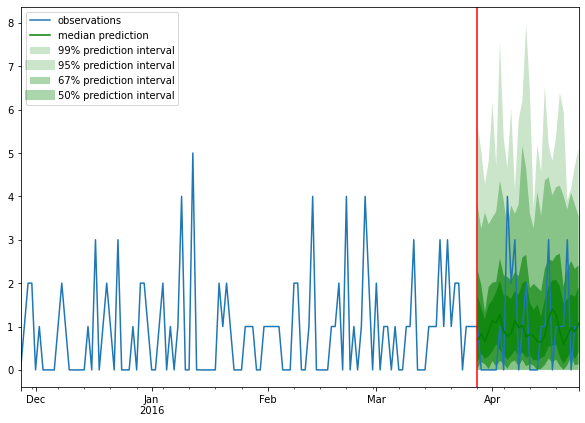

 20%|██        | 1/5 [00:01<00:06,  1.55s/it]

<Figure size 432x288 with 0 Axes>

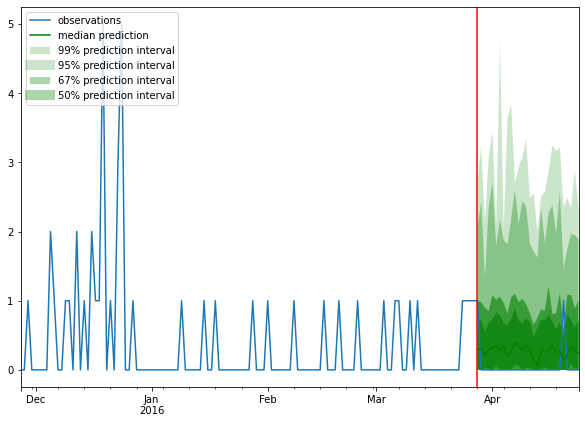

 40%|████      | 2/5 [00:02<00:03,  1.02s/it]

<Figure size 432x288 with 0 Axes>

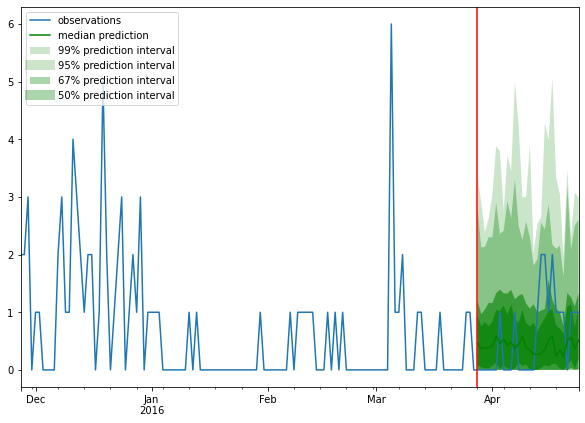

 60%|██████    | 3/5 [00:02<00:01,  1.26it/s]

<Figure size 432x288 with 0 Axes>

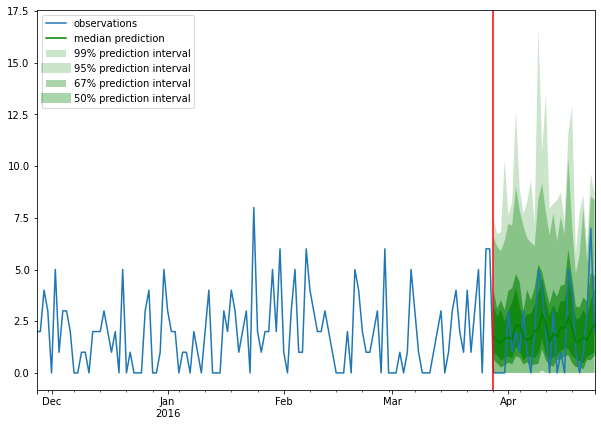

 80%|████████  | 4/5 [00:03<00:00,  1.43it/s]

<Figure size 432x288 with 0 Axes>

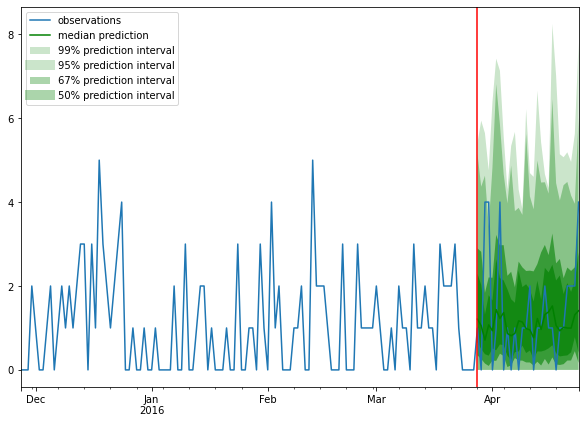

100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


<Figure size 432x288 with 0 Axes>

In [ ]:
plot_log_path = "./plots/"
directory = os.path.dirname(plot_log_path)

if not os.path.exists(directory):
    os.makedirs(directory)
    
def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
    plot_length = 150
    prediction_intervals = (50, 67, 95, 99)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    if inline:
        plt.show()
        plt.clf()
    else:
        plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
        plt.close()

print("Plotting time series predictions ...")
for i in tqdm(range(5)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)

# Electricity Dataset

In [26]:
from gluonts.dataset.loader import TrainDataLoader
from gluonts.dataset.repository.datasets import get_dataset

In [27]:
dataset = get_dataset(dataset_name="electricity")

In [28]:

estimator = DeepAREstimator(
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    distr_output = TweedieOutput(),
    #num_feat_dynamic_real=,
    #num_feat_static_cat=,
    trainer_kwargs = {
        #'learning_rate':1e-3,
        'auto_lr_find':True,
        'max_epochs':100,
        #'early_stop_callback': EarlyStopping(monitor="val_accuracy", min_delta=0.00, patience=3, verbose=False, mode="max")
    }
)

In [29]:
train_output = estimator.train(dataset.train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name  | Type                  | Params
------------------------------------------------
0 | model | DeepARModel           | 27.6 K
1 | loss  | NegativeLogLikelihood | 0     
------------------------------------------------
27.6 K    Trainable params
0         Non-trainable params
27.6 K    Total params
0.110     Total estimated model params size (MB)


Sdfsd
Epoch 0: : 0it [00:00, ?it/s]

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


Epoch 0: : 1it [00:00,  1.34it/s, loss=508, v_num=76]

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class '__main__.Tweedie'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch 0: : 50it [00:11,  4.18it/s, loss=1.01e+03, v_num=76, train_loss=2.01e+3]

Epoch 0, global step 50: 'train_loss' reached 2012.45325 (best 2012.45325), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_76/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [00:12,  3.93it/s, loss=308, v_num=76, train_loss=433.0]       

Epoch 1, global step 100: 'train_loss' reached 433.05527 (best 433.05527), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_76/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [00:12,  4.10it/s, loss=245, v_num=76, train_loss=229.0]

Epoch 2, global step 150: 'train_loss' reached 228.86205 (best 228.86205), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_76/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: : 50it [00:11,  4.28it/s, loss=219, v_num=76, train_loss=222.0]

Epoch 3, global step 200: 'train_loss' reached 221.97774 (best 221.97774), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_76/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: : 50it [00:15,  3.13it/s, loss=225, v_num=76, train_loss=211.0]

Epoch 4, global step 250: 'train_loss' reached 211.19150 (best 211.19150), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_76/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: : 50it [00:14,  3.35it/s, loss=194, v_num=76, train_loss=206.0]

Epoch 5, global step 300: 'train_loss' reached 205.88010 (best 205.88010), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_76/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: : 50it [00:12,  4.16it/s, loss=182, v_num=76, train_loss=195.0]

Epoch 6, global step 350: 'train_loss' reached 195.42459 (best 195.42459), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_76/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: : 50it [00:12,  4.03it/s, loss=154, v_num=76, train_loss=161.0]

Epoch 7, global step 400: 'train_loss' reached 161.03970 (best 161.03970), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_76/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: : 50it [00:12,  4.04it/s, loss=148, v_num=76, train_loss=152.0]

Epoch 8, global step 450: 'train_loss' reached 151.74126 (best 151.74126), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_76/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: : 50it [00:13,  3.66it/s, loss=124, v_num=76, train_loss=134.0]

Epoch 9, global step 500: 'train_loss' reached 133.89453 (best 133.89453), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_76/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: : 50it [00:13,  3.66it/s, loss=143, v_num=76, train_loss=141.0]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: : 50it [00:12,  3.97it/s, loss=140, v_num=76, train_loss=135.0]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: : 50it [00:13,  3.68it/s, loss=130, v_num=76, train_loss=140.0]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: : 50it [00:18,  2.75it/s, loss=131, v_num=76, train_loss=128.0]

Epoch 13, global step 700: 'train_loss' reached 128.09555 (best 128.09555), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_76/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: : 50it [00:15,  3.16it/s, loss=130, v_num=76, train_loss=131.0]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: : 50it [00:13,  3.75it/s, loss=140, v_num=76, train_loss=137.0]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: : 50it [00:12,  4.13it/s, loss=139, v_num=76, train_loss=138.0]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: : 50it [00:14,  3.35it/s, loss=125, v_num=76, train_loss=125.0]

Epoch 17, global step 900: 'train_loss' reached 125.01806 (best 125.01806), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_76/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: : 50it [00:21,  2.38it/s, loss=124, v_num=76, train_loss=129.0]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: : 50it [00:13,  3.61it/s, loss=133, v_num=76, train_loss=136.0]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: : 50it [00:14,  3.55it/s, loss=127, v_num=76, train_loss=132.0]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: : 50it [00:14,  3.36it/s, loss=142, v_num=76, train_loss=133.0]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: : 50it [00:13,  3.68it/s, loss=141, v_num=76, train_loss=132.0]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: : 50it [00:14,  3.37it/s, loss=133, v_num=76, train_loss=139.0]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: : 50it [00:12,  4.14it/s, loss=131, v_num=76, train_loss=127.0]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: : 50it [00:13,  3.67it/s, loss=138, v_num=76, train_loss=141.0]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: : 50it [00:12,  3.87it/s, loss=137, v_num=76, train_loss=137.0]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: : 50it [00:12,  4.16it/s, loss=137, v_num=76, train_loss=137.0]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: : 50it [00:11,  4.17it/s, loss=142, v_num=76, train_loss=136.0]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: : 50it [00:12,  4.16it/s, loss=134, v_num=76, train_loss=138.0]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: : 50it [00:12,  4.11it/s, loss=141, v_num=76, train_loss=133.0]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: : 50it [00:11,  4.19it/s, loss=116, v_num=76, train_loss=128.0]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: : 50it [00:13,  3.84it/s, loss=127, v_num=76, train_loss=131.0]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: : 50it [00:12,  3.88it/s, loss=136, v_num=76, train_loss=129.0]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: : 50it [00:15,  3.26it/s, loss=120, v_num=76, train_loss=130.0]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: : 50it [00:14,  3.49it/s, loss=142, v_num=76, train_loss=131.0]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: : 50it [00:13,  3.83it/s, loss=136, v_num=76, train_loss=133.0]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: : 50it [00:13,  3.73it/s, loss=135, v_num=76, train_loss=140.0]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: : 50it [00:12,  3.91it/s, loss=133, v_num=76, train_loss=134.0]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: : 50it [00:13,  3.81it/s, loss=132, v_num=76, train_loss=136.0]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: : 50it [00:12,  3.87it/s, loss=137, v_num=76, train_loss=133.0]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: : 50it [00:12,  3.88it/s, loss=134, v_num=76, train_loss=138.0]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: : 50it [00:13,  3.80it/s, loss=125, v_num=76, train_loss=130.0]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: : 50it [00:11,  4.35it/s, loss=134, v_num=76, train_loss=134.0]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: : 50it [00:11,  4.21it/s, loss=132, v_num=76, train_loss=129.0]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: : 50it [00:12,  4.13it/s, loss=141, v_num=76, train_loss=137.0]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: : 50it [00:11,  4.21it/s, loss=127, v_num=76, train_loss=132.0]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: : 50it [00:12,  4.15it/s, loss=141, v_num=76, train_loss=143.0]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: : 50it [00:12,  3.99it/s, loss=127, v_num=76, train_loss=129.0]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: : 50it [00:11,  4.22it/s, loss=137, v_num=76, train_loss=138.0]

Epoch 49, global step 2500: 'train_loss' was not in top 1


Epoch 50: : 50it [00:12,  4.13it/s, loss=141, v_num=76, train_loss=139.0]

Epoch 50, global step 2550: 'train_loss' was not in top 1


Epoch 51: : 50it [00:12,  4.07it/s, loss=134, v_num=76, train_loss=130.0]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: : 50it [00:11,  4.19it/s, loss=126, v_num=76, train_loss=129.0]

Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: : 50it [00:12,  4.12it/s, loss=132, v_num=76, train_loss=132.0]

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: : 50it [00:12,  3.96it/s, loss=133, v_num=76, train_loss=137.0]

Epoch 54, global step 2750: 'train_loss' was not in top 1


Epoch 55: : 50it [00:13,  3.83it/s, loss=124, v_num=76, train_loss=122.0]

Epoch 55, global step 2800: 'train_loss' reached 121.85425 (best 121.85425), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_76/checkpoints/epoch=55-step=2800.ckpt' as top 1


Epoch 56: : 50it [00:14,  3.40it/s, loss=145, v_num=76, train_loss=137.0]

Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: : 50it [00:13,  3.75it/s, loss=132, v_num=76, train_loss=129.0]

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: : 50it [00:13,  3.71it/s, loss=139, v_num=76, train_loss=132.0]

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: : 50it [00:13,  3.74it/s, loss=134, v_num=76, train_loss=128.0]

Epoch 59, global step 3000: 'train_loss' was not in top 1


Epoch 60: : 50it [00:13,  3.76it/s, loss=126, v_num=76, train_loss=131.0]

Epoch 60, global step 3050: 'train_loss' was not in top 1


Epoch 61: : 50it [00:13,  3.59it/s, loss=132, v_num=76, train_loss=129.0]

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: : 50it [00:12,  3.85it/s, loss=136, v_num=76, train_loss=135.0]

Epoch 62, global step 3150: 'train_loss' was not in top 1


Epoch 63: : 50it [00:12,  4.16it/s, loss=125, v_num=76, train_loss=132.0]

Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: : 50it [00:11,  4.18it/s, loss=132, v_num=76, train_loss=135.0]

Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: : 50it [00:12,  4.08it/s, loss=134, v_num=76, train_loss=129.0]

Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: : 50it [00:11,  4.30it/s, loss=137, v_num=76, train_loss=129.0]

Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: : 50it [00:11,  4.19it/s, loss=132, v_num=76, train_loss=131.0]

Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: : 50it [00:11,  4.25it/s, loss=131, v_num=76, train_loss=126.0]

Epoch 68, global step 3450: 'train_loss' was not in top 1


Epoch 69: : 50it [00:14,  3.42it/s, loss=133, v_num=76, train_loss=134.0]

Epoch 69, global step 3500: 'train_loss' was not in top 1


Epoch 70: : 50it [00:12,  4.00it/s, loss=131, v_num=76, train_loss=133.0]

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: : 50it [00:11,  4.20it/s, loss=141, v_num=76, train_loss=145.0]

Epoch 71, global step 3600: 'train_loss' was not in top 1


Epoch 72: : 50it [00:11,  4.27it/s, loss=127, v_num=76, train_loss=127.0]

Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: : 50it [00:12,  4.17it/s, loss=142, v_num=76, train_loss=134.0]

Epoch 73, global step 3700: 'train_loss' was not in top 1


Epoch 74: : 50it [00:11,  4.28it/s, loss=131, v_num=76, train_loss=127.0]

Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: : 50it [00:11,  4.22it/s, loss=141, v_num=76, train_loss=131.0]

Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: : 50it [00:12,  3.98it/s, loss=134, v_num=76, train_loss=134.0]

Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: : 50it [00:13,  3.72it/s, loss=134, v_num=76, train_loss=133.0]

Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: : 50it [00:14,  3.35it/s, loss=128, v_num=76, train_loss=126.0]

Epoch 78, global step 3950: 'train_loss' was not in top 1


Epoch 79: : 50it [00:16,  3.07it/s, loss=133, v_num=76, train_loss=133.0]

Epoch 79, global step 4000: 'train_loss' was not in top 1


Epoch 80: : 50it [00:14,  3.45it/s, loss=132, v_num=76, train_loss=127.0]

Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: : 50it [00:12,  4.16it/s, loss=134, v_num=76, train_loss=130.0]

Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: : 50it [00:12,  3.94it/s, loss=140, v_num=76, train_loss=142.0]

Epoch 82, global step 4150: 'train_loss' was not in top 1


Epoch 83: : 50it [00:12,  3.88it/s, loss=144, v_num=76, train_loss=135.0]

Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: : 50it [00:12,  3.97it/s, loss=130, v_num=76, train_loss=128.0]

Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: : 50it [00:13,  3.62it/s, loss=142, v_num=76, train_loss=136.0]

Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: : 50it [00:13,  3.71it/s, loss=128, v_num=76, train_loss=131.0]

Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: : 50it [00:14,  3.38it/s, loss=142, v_num=76, train_loss=136.0]

Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: : 50it [00:12,  3.95it/s, loss=135, v_num=76, train_loss=131.0]

Epoch 88, global step 4450: 'train_loss' was not in top 1


Epoch 89: : 50it [00:12,  3.91it/s, loss=132, v_num=76, train_loss=133.0]

Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: : 50it [00:10,  4.57it/s, loss=131, v_num=76, train_loss=131.0]

Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: : 50it [00:11,  4.29it/s, loss=129, v_num=76, train_loss=132.0]

Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: : 50it [00:13,  3.75it/s, loss=133, v_num=76, train_loss=133.0]

Epoch 92, global step 4650: 'train_loss' was not in top 1


Epoch 93: : 50it [00:11,  4.20it/s, loss=132, v_num=76, train_loss=128.0]

Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: : 50it [00:13,  3.78it/s, loss=134, v_num=76, train_loss=140.0]

Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: : 50it [00:11,  4.20it/s, loss=131, v_num=76, train_loss=129.0]

Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: : 50it [00:13,  3.66it/s, loss=135, v_num=76, train_loss=134.0]

Epoch 96, global step 4850: 'train_loss' was not in top 1


Epoch 97: : 50it [00:12,  3.96it/s, loss=136, v_num=76, train_loss=130.0]

Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: : 50it [00:15,  3.15it/s, loss=130, v_num=76, train_loss=132.0]

Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: : 50it [00:12,  4.02it/s, loss=133, v_num=76, train_loss=135.0]

Epoch 99, global step 5000: 'train_loss' was not in top 1


Epoch 99: : 50it [00:12,  4.02it/s, loss=133, v_num=76, train_loss=135.0]


/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(


In [30]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=train_output,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(dataset.test)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(dataset.test)))

Obtaining time series conditioning values ...


Epoch 69: : 30it [23:12, 46.42s/it, loss=132, v_num=75, train_loss=134.0]

  6%|▌         | 129/2247 [00:11<00:18, 114.54it/s]IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out

  6%|▌         | 130/2247 [00:41<31:52,  1.11it/s] IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


100%|██████████| 2247/2247 [01:13<00:00, 30.63it/s] 


Obtaining time series predictions ...


 27%|██▋       | 609/2247 [00:14<00:35, 45.53it/s]/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class '__main__.Tweedie'> does not define `arg_constra

In [31]:
from gluonts.evaluation import  Evaluator
evaluator = Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 2247/2247 [00:00<00:00, 4572.94it/s]
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/evaluation/_base.py:303: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for js

{
    "MSE": 17422617.74940544,
    "abs_error": 51755130.653404474,
    "abs_target_sum": 128632956.0,
    "abs_target_mean": 2385.272140631948,
    "seasonal_error": 189.4933819611677,
    "MASE": 6.395146305920879,
    "MAPE": 1.4216254868028142,
    "sMAPE": 0.34979830203919665,
    "MSIS": 57.53007122255349,
    "QuantileLoss[0.5]": 51755130.647196576,
    "Coverage[0.5]": 0.8498182762201432,
    "QuantileLoss[0.67]": 47988916.06404041,
    "Coverage[0.67]": 0.9420523661177852,
    "QuantileLoss[0.95]": 23628879.072414704,
    "Coverage[0.95]": 0.990209167779261,
    "QuantileLoss[0.99]": 15105834.677331045,
    "Coverage[0.99]": 0.9933244325767686,
    "RMSE": 4174.040937677234,
    "NRMSE": 1.7499223114102924,
    "ND": 0.40234736309258473,
    "wQuantileLoss[0.5]": 0.40234736304432417,
    "wQuantileLoss[0.67]": 0.3730685942103391,
    "wQuantileLoss[0.95]": 0.18369226524200147,
    "wQuantileLoss[0.99]": 0.11743362779699353,
    "mean_absolute_QuantileLoss": 34619690.115245685

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/pandas/core/construction.py:781: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)


# M4 hourly dataset

In [32]:
dataset = get_dataset(dataset_name="m4_hourly")

In [33]:

estimator = DeepAREstimator(
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    distr_output = TweedieOutput(),
    #num_feat_dynamic_real=,
    #num_feat_static_cat=,
    trainer_kwargs = {
        #'learning_rate':1e-3,
        'auto_lr_find':True,
        'max_epochs':100,
        #'early_stop_callback': EarlyStopping(monitor="val_accuracy", min_delta=0.00, patience=3, verbose=False, mode="max")
    }
)

In [34]:
train_output = estimator.train(dataset.train)

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sdfsd


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name  | Type                  | Params
------------------------------------------------
0 | model | DeepARModel           | 27.6 K
1 | loss  | NegativeLogLikelihood | 0     
------------------------------------------------
27.6 K    Trainable params
0         Non-trainable params
27.6 K    Total params
0.110     Total estimated model params size (MB)


Epoch 0: : 0it [00:00, ?it/s]

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/Users/poulamisar

Epoch 0: : 1it [00:00,  2.90it/s, loss=3.08e+04, v_num=77]

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class '__main__.Tweedie'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch 0: : 4it [00:01,  3.71it/s, loss=3e+04, v_num=77]   

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class '__main__.Tweedie'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initia

Epoch 0: : 50it [00:10,  4.90it/s, loss=2.25e+03, v_num=77, train_loss=5.75e+3]

Epoch 0, global step 50: 'train_loss' reached 5753.56494 (best 5753.56494), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [00:09,  5.53it/s, loss=412, v_num=77, train_loss=1.76e+3]     

Epoch 1, global step 100: 'train_loss' reached 1756.37488 (best 1756.37488), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [00:04, 10.66it/s, loss=1.02e+03, v_num=77, train_loss=1.3e+3] 

Epoch 2, global step 150: 'train_loss' reached 1295.42444 (best 1295.42444), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: : 50it [00:04, 11.40it/s, loss=1.01e+03, v_num=77, train_loss=1.32e+3]

Epoch 3, global step 200: 'train_loss' was not in top 1


Epoch 4: : 50it [00:04, 11.20it/s, loss=1.61e+03, v_num=77, train_loss=1.14e+3]

Epoch 4, global step 250: 'train_loss' reached 1136.12769 (best 1136.12769), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: : 50it [00:04, 10.05it/s, loss=1.65e+03, v_num=77, train_loss=1.07e+3]

Epoch 5, global step 300: 'train_loss' reached 1073.98364 (best 1073.98364), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: : 50it [00:05,  9.86it/s, loss=933, v_num=77, train_loss=778.0]       

Epoch 6, global step 350: 'train_loss' reached 778.15576 (best 778.15576), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: : 50it [00:04, 12.07it/s, loss=350, v_num=77, train_loss=405.0]

Epoch 7, global step 400: 'train_loss' reached 404.99973 (best 404.99973), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: : 50it [00:04, 11.97it/s, loss=186, v_num=77, train_loss=296.0]

Epoch 8, global step 450: 'train_loss' reached 295.73239 (best 295.73239), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: : 50it [00:04, 12.00it/s, loss=168, v_num=77, train_loss=261.0]

Epoch 9, global step 500: 'train_loss' reached 261.28552 (best 261.28552), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: : 50it [00:04, 12.16it/s, loss=202, v_num=77, train_loss=236.0]

Epoch 10, global step 550: 'train_loss' reached 236.47194 (best 236.47194), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: : 50it [00:04, 12.01it/s, loss=200, v_num=77, train_loss=221.0] 

Epoch 11, global step 600: 'train_loss' reached 220.76822 (best 220.76822), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: : 50it [00:04, 11.96it/s, loss=167, v_num=77, train_loss=134.0] 

Epoch 12, global step 650: 'train_loss' reached 133.71382 (best 133.71382), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=12-step=650.ckpt' as top 1


Epoch 13: : 50it [00:04, 12.10it/s, loss=153, v_num=77, train_loss=144.0] 

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: : 50it [00:04, 11.84it/s, loss=128, v_num=77, train_loss=129.0] 

Epoch 14, global step 750: 'train_loss' reached 129.41563 (best 129.41563), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=14-step=750.ckpt' as top 1


Epoch 15: : 50it [00:04, 11.75it/s, loss=104, v_num=77, train_loss=146.0] 

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: : 50it [00:04, 11.85it/s, loss=96.6, v_num=77, train_loss=119.0]

Epoch 16, global step 850: 'train_loss' reached 118.65805 (best 118.65805), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: : 50it [00:04, 11.72it/s, loss=114, v_num=77, train_loss=137.0] 

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: : 50it [00:04, 12.01it/s, loss=161, v_num=77, train_loss=151.0] 

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: : 50it [00:04, 12.13it/s, loss=152, v_num=77, train_loss=135.0] 

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: : 50it [00:04, 12.07it/s, loss=128, v_num=77, train_loss=131.0] 

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: : 50it [00:04, 12.16it/s, loss=92, v_num=77, train_loss=122.0]  

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: : 50it [00:04, 12.07it/s, loss=90.4, v_num=77, train_loss=134.0]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: : 50it [00:04, 11.92it/s, loss=95.5, v_num=77, train_loss=120.0]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: : 50it [00:04, 12.21it/s, loss=154, v_num=77, train_loss=127.0] 

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: : 50it [00:04, 12.17it/s, loss=146, v_num=77, train_loss=126.0] 

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: : 50it [00:04, 12.16it/s, loss=91.5, v_num=77, train_loss=113.0]

Epoch 26, global step 1350: 'train_loss' reached 112.56145 (best 112.56145), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=26-step=1350.ckpt' as top 1


Epoch 27: : 50it [00:04, 12.06it/s, loss=86.5, v_num=77, train_loss=121.0]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: : 50it [00:04, 12.06it/s, loss=95, v_num=77, train_loss=128.0]  

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: : 50it [00:04, 11.78it/s, loss=116, v_num=77, train_loss=127.0] 

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: : 50it [00:04, 12.00it/s, loss=125, v_num=77, train_loss=114.0] 

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: : 50it [00:04, 12.06it/s, loss=144, v_num=77, train_loss=127.0] 

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: : 50it [00:04, 11.84it/s, loss=154, v_num=77, train_loss=122.0] 

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: : 50it [00:04, 12.11it/s, loss=122, v_num=77, train_loss=120.0] 

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: : 50it [00:04, 12.05it/s, loss=95.4, v_num=77, train_loss=122.0]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: : 50it [00:04, 12.03it/s, loss=116, v_num=77, train_loss=121.0] 

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: : 50it [00:04, 12.08it/s, loss=179, v_num=77, train_loss=150.0] 

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: : 50it [00:04, 11.91it/s, loss=152, v_num=77, train_loss=124.0] 

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: : 50it [00:04, 12.02it/s, loss=159, v_num=77, train_loss=128.0] 

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: : 50it [00:04, 12.11it/s, loss=103, v_num=77, train_loss=104.0] 

Epoch 39, global step 2000: 'train_loss' reached 103.94705 (best 103.94705), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=39-step=2000.ckpt' as top 1


Epoch 40: : 50it [00:04, 12.02it/s, loss=104, v_num=77, train_loss=138.0] 

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: : 50it [00:05,  9.56it/s, loss=86.3, v_num=77, train_loss=128.0]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: : 50it [00:04, 11.58it/s, loss=90.1, v_num=77, train_loss=111.0]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: : 50it [00:04, 11.90it/s, loss=160, v_num=77, train_loss=134.0] 

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: : 50it [00:04, 11.43it/s, loss=152, v_num=77, train_loss=137.0] 

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: : 50it [00:04, 11.80it/s, loss=138, v_num=77, train_loss=117.0] 

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: : 50it [00:04, 11.60it/s, loss=89, v_num=77, train_loss=111.0]  

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: : 50it [00:04, 11.44it/s, loss=75, v_num=77, train_loss=117.0]  

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: : 50it [00:04, 11.51it/s, loss=106, v_num=77, train_loss=130.0] 

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: : 50it [00:05,  9.83it/s, loss=149, v_num=77, train_loss=132.0] 

Epoch 49, global step 2500: 'train_loss' was not in top 1


Epoch 50: : 50it [00:05,  9.85it/s, loss=140, v_num=77, train_loss=121.0] 

Epoch 50, global step 2550: 'train_loss' was not in top 1


Epoch 51: : 50it [00:04, 11.56it/s, loss=155, v_num=77, train_loss=115.0] 

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: : 50it [00:04, 12.07it/s, loss=104, v_num=77, train_loss=114.0] 

Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: : 50it [00:04, 11.73it/s, loss=119, v_num=77, train_loss=140.0] 

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: : 50it [00:04, 12.12it/s, loss=111, v_num=77, train_loss=127.0] 

Epoch 54, global step 2750: 'train_loss' was not in top 1


Epoch 55: : 50it [00:04, 11.70it/s, loss=107, v_num=77, train_loss=121.0] 

Epoch 55, global step 2800: 'train_loss' was not in top 1


Epoch 56: : 50it [00:04, 11.16it/s, loss=174, v_num=77, train_loss=138.0] 

Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: : 50it [00:04, 10.51it/s, loss=144, v_num=77, train_loss=121.0] 

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: : 50it [00:04, 10.84it/s, loss=145, v_num=77, train_loss=125.0] 

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: : 50it [00:05,  9.87it/s, loss=155, v_num=77, train_loss=131.0] 

Epoch 59, global step 3000: 'train_loss' was not in top 1


Epoch 60: : 50it [00:04, 10.41it/s, loss=89.6, v_num=77, train_loss=96.60]

Epoch 60, global step 3050: 'train_loss' reached 96.58387 (best 96.58387), saving model to '/Users/poulamisarkar/Documents/TUM/sem2/seminar/glutons /lightning_logs/version_77/checkpoints/epoch=60-step=3050.ckpt' as top 1


Epoch 61: : 50it [00:04, 11.96it/s, loss=81, v_num=77, train_loss=126.0]  

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: : 50it [00:04, 11.84it/s, loss=72.3, v_num=77, train_loss=118.0]

Epoch 62, global step 3150: 'train_loss' was not in top 1


Epoch 63: : 50it [00:04, 12.01it/s, loss=80.9, v_num=77, train_loss=119.0]

Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: : 50it [00:04, 12.04it/s, loss=98.5, v_num=77, train_loss=122.0]

Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: : 50it [00:04, 11.78it/s, loss=122, v_num=77, train_loss=136.0] 

Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: : 50it [00:04, 12.07it/s, loss=140, v_num=77, train_loss=126.0] 

Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: : 50it [00:07,  6.90it/s, loss=157, v_num=77, train_loss=128.0] 

Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: : 50it [00:09,  5.41it/s, loss=150, v_num=77, train_loss=114.0] 

Epoch 68, global step 3450: 'train_loss' was not in top 1


Epoch 69: : 50it [00:09,  5.36it/s, loss=128, v_num=77, train_loss=116.0] 

Epoch 69, global step 3500: 'train_loss' was not in top 1


Epoch 70: : 50it [00:09,  5.51it/s, loss=104, v_num=77, train_loss=131.0] 

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: : 50it [00:08,  5.71it/s, loss=84.2, v_num=77, train_loss=128.0]

Epoch 71, global step 3600: 'train_loss' was not in top 1


Epoch 72: : 50it [00:04, 11.83it/s, loss=120, v_num=77, train_loss=128.0] 

Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: : 50it [00:04, 12.46it/s, loss=164, v_num=77, train_loss=136.0] 

Epoch 73, global step 3700: 'train_loss' was not in top 1


Epoch 74: : 50it [00:04, 12.42it/s, loss=140, v_num=77, train_loss=124.0] 

Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: : 50it [00:04, 12.33it/s, loss=149, v_num=77, train_loss=118.0] 

Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: : 50it [00:04, 12.48it/s, loss=150, v_num=77, train_loss=132.0] 

Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: : 50it [00:04, 12.46it/s, loss=105, v_num=77, train_loss=117.0] 

Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: : 50it [00:04, 12.20it/s, loss=90.1, v_num=77, train_loss=122.0]

Epoch 78, global step 3950: 'train_loss' was not in top 1


Epoch 79: : 50it [00:04, 12.41it/s, loss=98.1, v_num=77, train_loss=136.0]

Epoch 79, global step 4000: 'train_loss' was not in top 1


Epoch 80: : 50it [00:04, 12.06it/s, loss=99.5, v_num=77, train_loss=116.0]

Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: : 50it [00:04, 12.20it/s, loss=87, v_num=77, train_loss=112.0]  

Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: : 50it [00:03, 12.59it/s, loss=98.8, v_num=77, train_loss=125.0]

Epoch 82, global step 4150: 'train_loss' was not in top 1


Epoch 83: : 50it [00:04, 12.39it/s, loss=104, v_num=77, train_loss=122.0] 

Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: : 50it [00:03, 12.52it/s, loss=143, v_num=77, train_loss=118.0] 

Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: : 50it [00:04, 12.39it/s, loss=174, v_num=77, train_loss=138.0] 

Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: : 50it [00:04, 12.34it/s, loss=138, v_num=77, train_loss=110.0] 

Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: : 50it [00:04, 12.43it/s, loss=143, v_num=77, train_loss=133.0] 

Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: : 50it [00:04, 12.39it/s, loss=125, v_num=77, train_loss=127.0] 

Epoch 88, global step 4450: 'train_loss' was not in top 1


Epoch 89: : 50it [00:03, 12.57it/s, loss=83.1, v_num=77, train_loss=112.0]

Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: : 50it [00:04, 12.46it/s, loss=94.7, v_num=77, train_loss=119.0]

Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: : 50it [00:04, 12.34it/s, loss=109, v_num=77, train_loss=122.0] 

Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: : 50it [00:04, 12.34it/s, loss=104, v_num=77, train_loss=107.0] 

Epoch 92, global step 4650: 'train_loss' was not in top 1


Epoch 93: : 50it [00:04, 12.39it/s, loss=150, v_num=77, train_loss=133.0] 

Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: : 50it [00:04, 12.40it/s, loss=158, v_num=77, train_loss=125.0] 

Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: : 50it [00:04, 12.27it/s, loss=157, v_num=77, train_loss=118.0] 

Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: : 50it [00:04, 12.13it/s, loss=158, v_num=77, train_loss=129.0] 

Epoch 96, global step 4850: 'train_loss' was not in top 1


Epoch 97: : 50it [00:04, 12.44it/s, loss=118, v_num=77, train_loss=106.0] 

Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: : 50it [00:04, 12.26it/s, loss=89.8, v_num=77, train_loss=111.0]

Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: : 50it [00:04, 12.45it/s, loss=76.5, v_num=77, train_loss=119.0]

Epoch 99, global step 5000: 'train_loss' was not in top 1


Epoch 99: : 50it [00:04, 12.44it/s, loss=76.5, v_num=77, train_loss=119.0]


/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(


In [35]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=train_output,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(dataset.test)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(dataset.test)))

Obtaining time series conditioning values ...


100%|██████████| 414/414 [00:00<00:00, 2029.21it/s]


Obtaining time series predictions ...


100%|██████████| 414/414 [00:11<00:00, 35.42it/s]


In [36]:
from gluonts.evaluation import  Evaluator
evaluator = Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 2394.64it/s]
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-han

{
    "MSE": 374092719.39790845,
    "abs_error": 70274618.93756485,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 13.082273673020454,
    "MAPE": 0.309689604093871,
    "sMAPE": 0.34713537800283206,
    "MSIS": 198.98100079538418,
    "QuantileLoss[0.5]": 70274617.56427956,
    "Coverage[0.5]": 0.26514694041867953,
    "QuantileLoss[0.67]": 91041660.86751877,
    "Coverage[0.67]": 0.5049315619967791,
    "QuantileLoss[0.95]": 116309231.99276006,
    "Coverage[0.95]": 0.677636876006441,
    "QuantileLoss[0.99]": 114818021.3358506,
    "Coverage[0.99]": 0.7208635265700485,
    "RMSE": 19341.4766602219,
    "NRMSE": 2.640538780580044,
    "ND": 0.4827917531073212,
    "wQuantileLoss[0.5]": 0.48279174367275113,
    "wQuantileLoss[0.67]": 0.6254628444884553,
    "wQuantileLoss[0.95]": 0.7990528994008455,
    "wQuantileLoss[0.99]": 0.7888081735213459,
    "mean_absolute_QuantileLoss": 98110882.9401022